## Color Magnification

Code to reveal hidden color variations in videos.

In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from glob import glob

Get video path

Add the path in data_path variable

In [2]:
DATA_PATH = 'Videos'
VIDEO_NAME = 'Video.mp4'

VIDEO_PATH = os.path.join(DATA_PATH, VIDEO_NAME)
os.path.exists(VIDEO_PATH)

True

## Set Hyperparameters

In [3]:
# Video magnification factor
ALPHA = 50.0

# Gaussian Pyramind level of which to apply mangification
LEVEL = 4

# Temporal Filter parameters
f_lo = 50/60
f_hi = 60/60

# OPTIONAL: override fs
MANUAL_FS = None
VIDEO_FS = None

# video frame scale factor
SCALE_FACTOR = 1.0

## Colorspace functions

In [4]:
def rgb2yiq(rgb):
    """Converts an RGB image to YIQ using FCC NTSC format.
        This is a numpy version of the colorsys implementation
        Inputs:
            rgb - (N, M, 3) rgb image
        Returns:
            yiq - (N, M, 3) yiq image
    """
    y = rgb @ np.array([[0.30], [0.59], [0.11]])
    # subtract y channel from red and blue channels
    rby = rgb[:, :, (0,2)] - y

    i = np.sum(rby * np.array([[[0.74, -0.27]]]), axis=-1)
    q = np.sum(rby * np.array([[[0.48, 0.41]]]), axis=-1)

    yiq = np.dstack((y.squeeze(), i, q))
    
    return yiq

def bgr2yiq(bgr):
    """ Coverts a BGR image to float32 YIQ """
    # get normalized YIQ frame
    rgb = np.float32(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    yiq = rgb2yiq(rgb)

    return yiq

def yiq2rgb(yiq):
    """ Converts a YIQ image to RGB.
        Inputs:
            yiq - (N,M,3) YIQ image
        Outputs:
            rgb - (N,M,3) rgb image
        """
    r = yiq @ np.array([1.0, 0.9468822170900693, 0.6235565819861433])
    g = yiq @ np.array([1.0, -0.27478764629897834, -0.6356910791873801])
    b = yiq @ np.array([1.0, -1.1085450346420322, 1.7090069284064666])
    rgb = np.clip(np.dstack((r, g, b)), 0, 1)
    return rgb

In [5]:
inv_colorspace = lambda x: cv2.normalize(
    yiq2rgb(x), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3
)

### Get video frames

In [6]:
frames = []
cap = cv2.VideoCapture(VIDEO_PATH)

fs = cap.get(cv2.CAP_PROP_FPS)

idx = 0

while(cap.isOpened()):
    ret, frame = cap.read() 
    if not ret: 
        break 
    if idx == 0: 
        og_h, og_w, _ = frame.shape
        w = int(og_w*SCALE_FACTOR)
        h = int(og_h*SCALE_FACTOR)

    # bgr to other color space 
    frame = bgr2yiq(np.float32(frame/255)) 
    frames.append(cv2.resize(frame, (w, h)))
    idx += 1

cap.release()
cv2.destroyAllWindows()
del cap

In [7]:
NUM_FRAMES = len(frames) 
NUM_FRAMES

300

In [8]:
frames[0].min(axis=0).min(axis=0), frames[0].max(axis=0).max(axis=0)

(array([ 0.        , -0.01044079, -0.20672667]),
 array([0.89019608, 0.23743451, 0.05289608]))

Override sampling frequency

In [9]:
print(f"Detected Video sampling rate: {fs}")

if MANUAL_FS:
    print(f"Overriding to: {MANUAL_FS}")
    fs = MANUAL_FS
    VIDEO_FS = fs
else:
    VIDEO_FS = fs

Detected Video sampling rate: 30.0


## Get Temporal filter

In [10]:
import scipy.signal as signal

bandpass = signal.firwin(numtaps=NUM_FRAMES, 
                         cutoff=(f_lo, f_hi),
                         fs=fs,
                         pass_zero=False)

In [11]:
transfer_function = np.fft.fft(np.fft.ifftshift(bandpass))

Text(0.5, 1.0, 'Transfer Function')

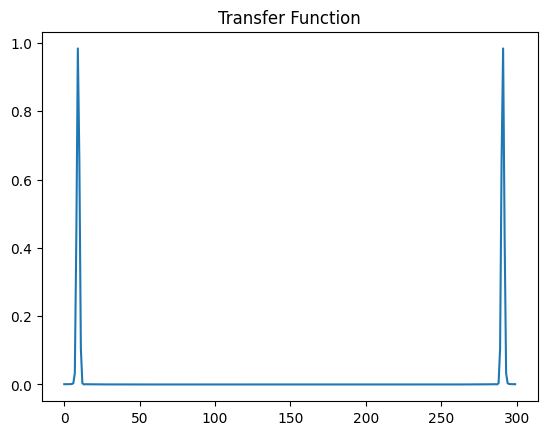

In [12]:
plt.plot(np.abs(transfer_function))
plt.title("Transfer Function")

Text(0.5, 1.0, 'Implse Response')

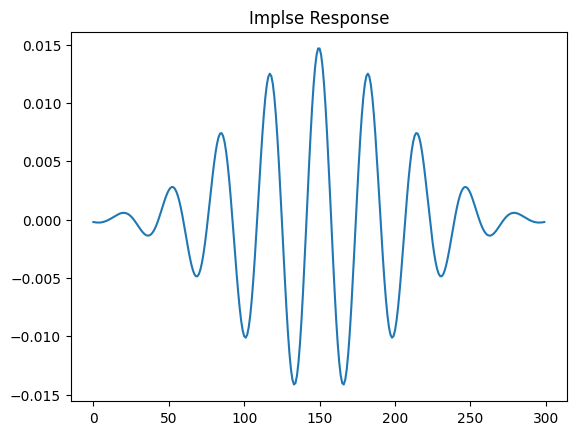

In [13]:
plt.plot(bandpass)
plt.title("Implse Response")

Text(0, 0.5, 'Angle (radians)')

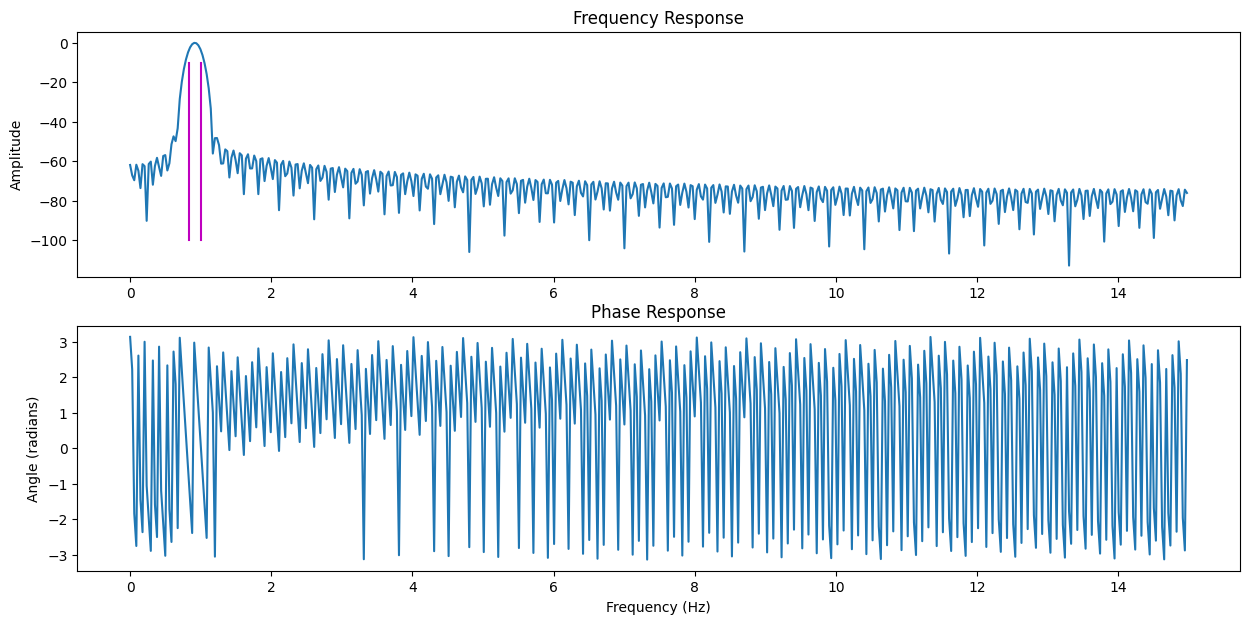

In [14]:
norm_freqs, response = signal.freqz(bandpass)
freqs = norm_freqs / np.pi * fs/ 2

_, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].plot(freqs, 20*np.log10(np.abs(response)))
ax[0].plot([f_lo, f_lo], [-100, -10], color='m')
ax[0].plot([f_hi, f_hi], [-100, -10], color='m')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude")

ax[1].plot(freqs, np.angle(response))
ax[1].set_title("Phase Response")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Angle (radians)")

In [15]:
def gaussian_pyramid(image, level): 
    """Obtains single band of a Gaussian Pyramid Decomposition
        Inputs:
         image - single channel input image 
         num_levels - number of pyramid level 
        Output: 
         pyramid - pyramid decomposition tensor
    """
    rows, cols, colors = image.shape
    scale = 2**level
    pyramid = np.zeros((colors, rows//scale, cols//scale))

    for i in range(0, level): 
        image = cv2.pyrDown(image, dstsize=(cols//2, rows//2))
        rows, cols, _ = image.shape 

        if i == (level-1): 
            for c in range(colors): 
                pyramid[c, :, :] = image[:, :, c] 
    return pyramid

In [16]:
rows, cols, colors = frames[0].shape 
scale = 2**LEVEL 
pyramid_stack = np.zeros((NUM_FRAMES, colors, rows//scale, cols//scale))

In [17]:
for i, frame in enumerate(frames): 
    pyramid = gaussian_pyramid(frame, LEVEL) 
    pyramid_stack[i, :, :, :] = pyramid

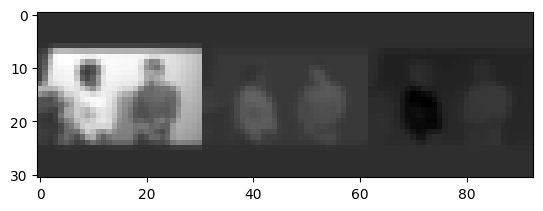

In [18]:
plt.imshow(pyramid_stack[0, :, :, :].transpose(1, 0, 2).reshape((pyramid.shape[1], -1)), cmap='gray');

## Apply Temporal Filtering

In [19]:
pyr_stack_fft = np.fft.fft(pyramid_stack, axis=0).astype(np.complex64)
_filtered_pyramid = pyr_stack_fft*transfer_function[:, None, None, None].astype(np.complex64)
filter_pyramid = np.fft.ifft(_filtered_pyramid, axis=0).real

In [20]:
pyr_stack_fft.shape

(300, 3, 31, 31)

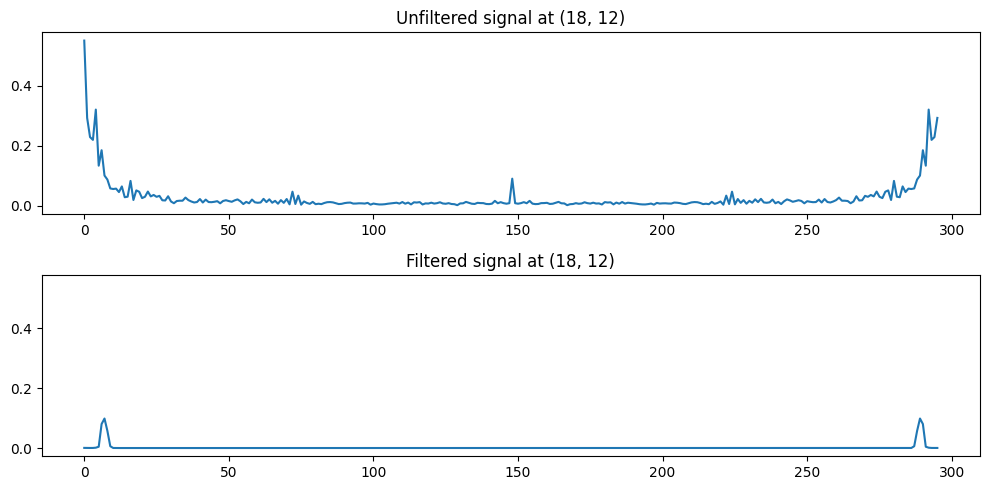

In [21]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,5), sharey=True)
ax0.plot(np.abs(pyr_stack_fft[2:-2, 0, 17, 12]))
ax0.set_title("Unfiltered signal at (18, 12)")

ax1.plot(np.abs(_filtered_pyramid[2:-2, 0, 17, 12]))
ax1.set_title("Filtered signal at (18, 12)");abs

plt.tight_layout();

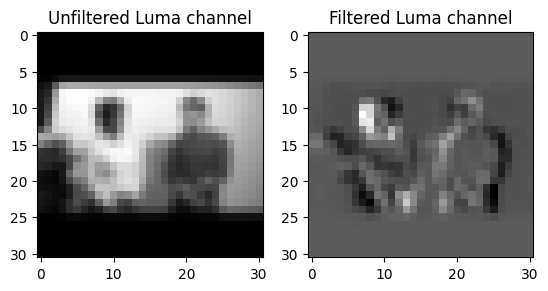

In [22]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(pyramid_stack[50, 0, :, :], cmap='gray')
ax[0].set_title("Unfiltered Luma channel")
ax[1].imshow(filter_pyramid[50, 0, :, :], cmap='gray')
ax[1].set_title("Filtered Luma channel");

Display filtered results at single pixel

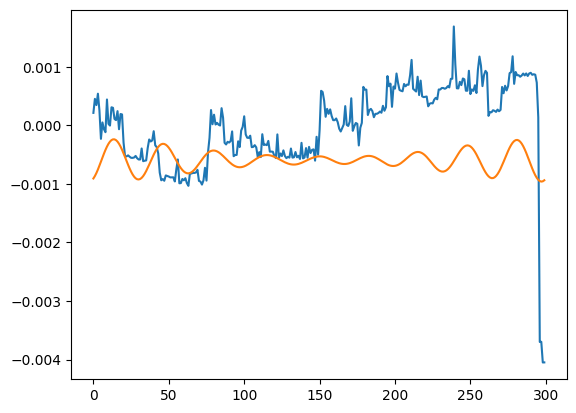

In [23]:
plt.plot(pyramid_stack[:, 0, 12, 17]-pyramid_stack[:, 0, 12, 17].mean())
plt.plot(filter_pyramid[:, 0, 12, 17]);

## Apply magnification and reconstruct video

In [24]:
magnified_pyramid = filter_pyramid * ALPHA

In [25]:
magnified = []
magnified_only = []

for i in range(NUM_FRAMES):
    y_chan = frames[i][:, :, 0]
    i_chan = frames[i][:, :, 1]
    q_chan = frames[i][:, :, 2]

    fy_chan = cv2.resize(magnified_pyramid[i, 0, :, :], (cols, rows))
    fi_chan = cv2.resize(magnified_pyramid[i, 1, :, :], (cols, rows))
    fq_chan = cv2.resize(magnified_pyramid[i, 2, :, :], (cols, rows))

    mag = np.dstack((
        y_chan + fy_chan,
        i_chan + fi_chan, 
        q_chan + fq_chan,
    ))

    mag = inv_colorspace(mag)

    magnified.append(mag)

    magnified_only.append(np.dstack((fy_chan, fi_chan, fq_chan)))

Check detected heart rates

In [26]:
og_reds = [] 
og_blues = [] 
og_greens = [] 

reds = [] 
blues = [] 
greens = []

for i in range(NUM_FRAMES): 
    frame = inv_colorspace(frames[i])
    og_reds.append(frame[0, :, :].sum())
    og_blues.append(frame[1, :, :].sum())
    og_greens.append(frame[2, :, :].sum())

    reds.append(magnified[i][0, :, :].sum())
    blues.append(magnified[i][1, :, :].sum())
    greens.append(magnified[i][2, :, :].sum())
    

In [27]:
times = np.arange(0, NUM_FRAMES)/fs

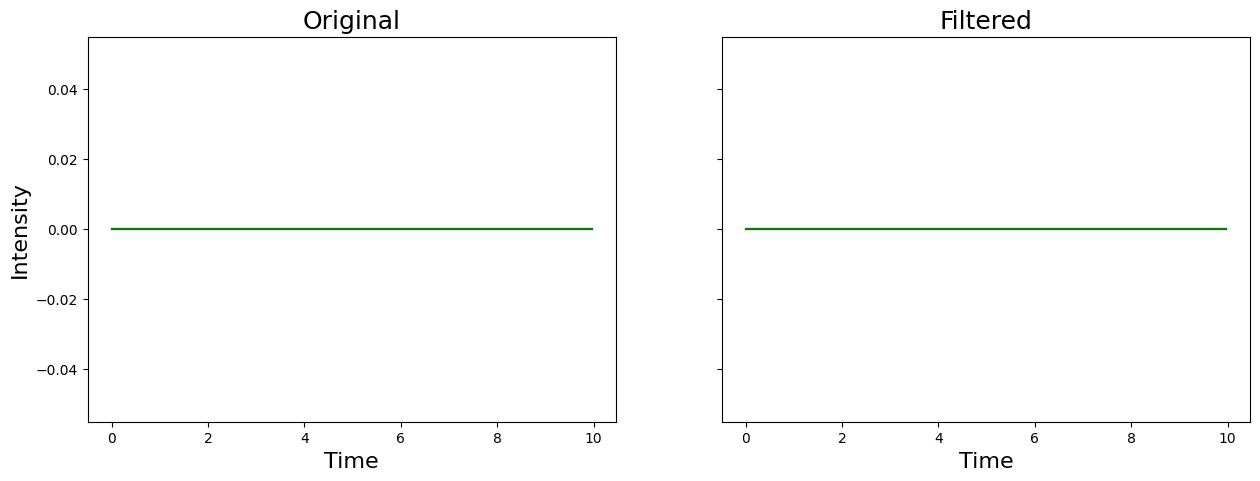

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].plot(times, og_reds, color='red')
ax[0].plot(times, og_blues, color='blue')
ax[0].plot(times, og_greens, color='green')
ax[0].set_title("Original", size=18)
ax[0].set_xlabel("Time", size=16)
ax[0].set_ylabel("Intensity", size=16)

ax[1].plot(times, reds, color='red')
ax[1].plot(times, blues, color='blue')
ax[1].plot(times, greens, color='green')
ax[1].set_title("Filtered", size=18)
ax[1].set_xlabel("Time", size=16);

In [29]:
freqs = np.fft.rfftfreq(NUM_FRAMES) * fs
rates = np.abs(np.fft.rfft(reds))/NUM_FRAMES

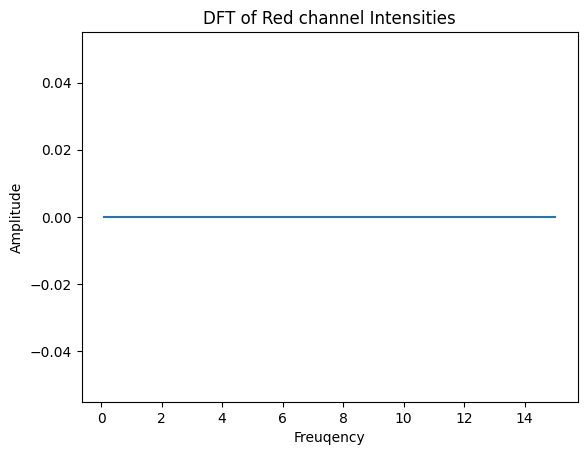

In [30]:
plt.plot(freqs[1:], rates[1:]);
plt.title("DFT of Red channel Intensities")
plt.xlabel("Freuqency")
plt.ylabel("Amplitude");

In [31]:
peak_idx, _ = signal.find_peaks(rates, height=1000)

In [32]:
freqs[peak_idx], rates[peak_idx]

(array([], dtype=float64), array([], dtype=float64))

In [33]:
bpm = freqs[peak_idx].squeeze(0) * 60
bpm

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [34]:
stacked_frames = []
middle = np.zeros((rows, 3, 3)).astype(np.uint8)

for vid_idx in range(NUM_FRAMES):
    og_frame = cv2.normalize(yiq2rgb(frames[vid_idx]), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)
    frame = np.hstack((cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR), 
                       middle, 
                       cv2.cvtColor(magnified[vid_idx], cv2.COLOR_RGB2BGR)))
    stacked_frames.append(frame)

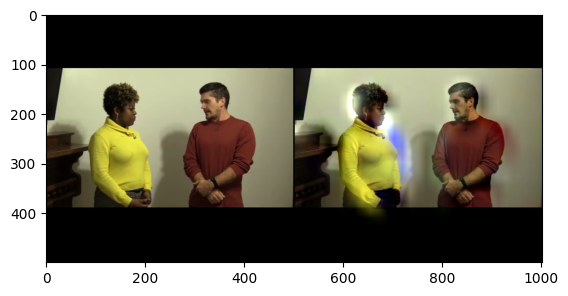

In [35]:
plt.imshow(cv2.cvtColor(stacked_frames[10], cv2.COLOR_BGR2RGB));

In [36]:


# get width and height for video frames
_h, _w, _ = stacked_frames[-1].shape

# save to mp4
out = cv2.VideoWriter(f"stacked_{int(ALPHA)}x.avi",
                      cv2.VideoWriter_fourcc(*'XVID'), 
                      int(fs), 
                      (_w, _h))
 
for frame in stacked_frames:
    out.write(frame)

out.release()
del out

